# Nonlinear Buckling of an Imperfect Euler's Column

***

In the [last notebook](06_Nonlinear_Buckling_Method_Verification.ipynb) we observed how a ribless box beam with a rigid tip section does not encounter a critical point under a concentrated vertical load applied at tip. SOL 106's nonlinear buckling method predicts a larger buckling load as the applied load is increased. In this notebook we want to test whether the same behavior can be observed for an imperfect Euler's column, whose equilibrium diagram consists in a broken pitchfork, where no critical point is present.

## Setup of the numerical model

***

We use the same model used in our notebook on [Euler's column supercritical pitchfork bifurcation](02_Supercritical_Pitchfork_Bifurcation_Euler_Column.ipynb).

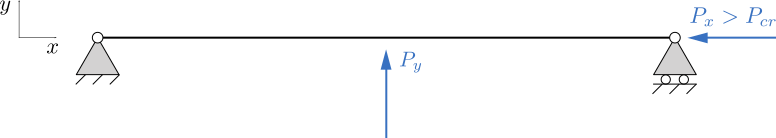

In [28]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '02_Subcase2.svg'))

In [29]:
from resources import column_utils
import numpy as np
from resources import pynastran_utils
# Create base bdf input
E = 207000.  # [MPa]
nu = 0.3
rho = 7.8e-4  # [tons/mm^3]
d = 20  # [mm]
l = 420  # [mm]
no_elements = 420
bdf_input = column_utils.create_base_bdf(young_modulus=E, poisson_ratio=nu, density=rho, diameter=d, length=l, no_elements=no_elements)
# Define transverse force
compression_force_set_id = list(bdf_input.loads.keys())[0]
transverse_force_set_id = compression_force_set_id+1
middle_node_id = int(no_elements/2+1)
sol105_buckling_load = 90578.  # [N]
transverse_force_magnitude = sol105_buckling_load/100  # [N]
transverse_force_direction = [0., 1., 0.]
bdf_input.add_force(sid=transverse_force_set_id, node=middle_node_id, mag=transverse_force_magnitude, xyz=transverse_force_direction)

subcase=0 already exists...skipping


FORCE          5     211          905.78      0.      1.      0.

## Run analysis

***

Setup SOL 106 with nonlinear buckling method.

In [30]:
# Assign solution sequence and analysis title
bdf_input.sol = 106
# Add parameter for large displacement effects and for buckling analysis
bdf_input.add_param('LGDISP', [1])
# Define general parameters for the nonlinear iteration strategy
nlparm_id = 1
bdf_input.add_nlparm(nlparm_id=nlparm_id, kmethod='ITER', kstep=1, int_out='YES', conv='PW', eps_p=1e-2, eps_w=1e-2)
# Define parameters for the arc-length method
bdf_input.add_nlpci(nlpci_id=nlparm_id, Type='CRIS', desiter=5, minalr=.25, maxalr=4., mxinc=100)
# Add NLPARM id to the control case commands
bdf_input.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)
# Parameters for buckling analysis
bdf_input.add_param('BUCKLE', [2])
eigrl_set_id = transverse_force_set_id+1
bdf_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)
bdf_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)

Monitor lowest eigenvalue of tangent stiffness matrix.

In [31]:
import os
bdf_input.executive_control_lines[1:1] = ['include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_lowest_eigv_test.dmap') + '\'']  # include DMAP sequence

Define subcases.

In [32]:
compression_load_magnitudes = np.linspace(0, sol105_buckling_load*2, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f'Applied compression loads [N]: {compression_load_magnitudes}')
for i, scale_factor in enumerate(compression_load_magnitudes):
    load_set_id = 11+i
    bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor, 1.], load_ids=[compression_force_set_id, transverse_force_set_id])
    pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=i+1, load_set_id=load_set_id)

Applied compression loads [N]: [ 18116.  36231.  54347.  72462.  90578. 108694. 126809. 144925. 163040.
 181156.]


Run analysis

In [33]:
# Define name of analysis directory
analysis_directory_name = '07_Nonlinear_Buckling_Imperfect_Euler_Column'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Run analysis
input_filename = 'nonlinear_buckling_verification'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, bdf_filename=input_filename, run_flag=False)

Plot load history

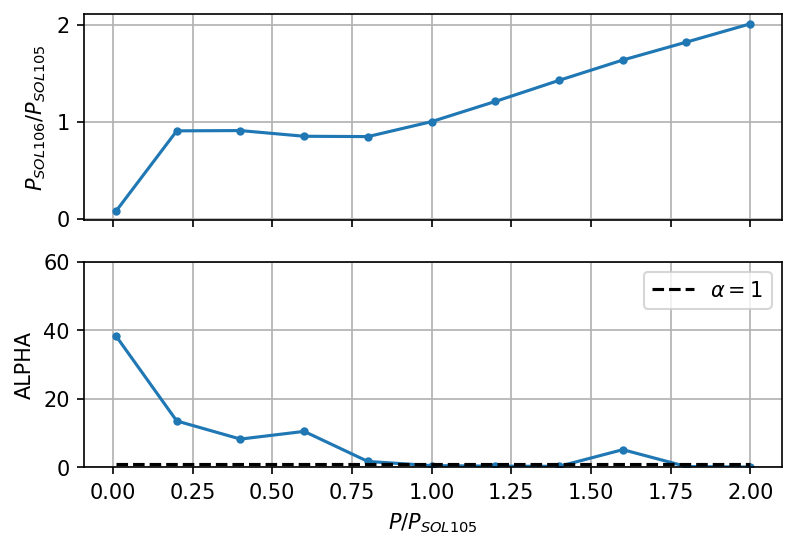

In [34]:
from pyNastran.op2.op2 import read_op2  # function to read op2 file
import matplotlib.pyplot as plt  # plotting library
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=False)
# Find load and displacement history
load_steps, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)
# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_filename + '.f06'), op2_object=op2_output)
# Set default dpi of figures
plt.rcParams['figure.dpi'] = 150
# Collect loads and displacements of interest
applied_loads = np.array([np.linalg.norm(loads[subcase_id][-1,:]) for subcase_id in loads])
load_history = np.concatenate([np.linalg.norm(loads[subcase_id], axis=1) for subcase_id in loads])
displacement_history = np.concatenate([displacements[subcase_id][:,5] for subcase_id in displacements])
# Create figure with subplots
fig, axs = plt.subplots(nrows=2, ncols=1, sharex='all')
# Plot applied loads vs buckling loads
axs[0].plot(applied_loads/sol105_buckling_load, nonlinear_buckling_loads/sol105_buckling_load, '.-')
# Plot applied loads vs critical buckling factors
axs[1].plot(applied_loads/sol105_buckling_load, critical_buckling_factors, '.-')
reference, = axs[1].plot(applied_loads/sol105_buckling_load, [1]*len(applied_loads), '--k', label='$\\alpha=1$')
# Set plot appearance
axs[0].set_ylabel('$P_{SOL 106}/P_{SOL 105}$')
axs[0].grid(visible=True)
axs[1].set_ylabel('ALPHA')
axs[1].grid(visible=True)
axs[1].legend(handles=[reference])
axs[1].set_xlabel('$P/P_{SOL 105}$')
axs[1].set_ylim([0, 60])
# Show plot
plt.show()

Plot equilibrium diagram.

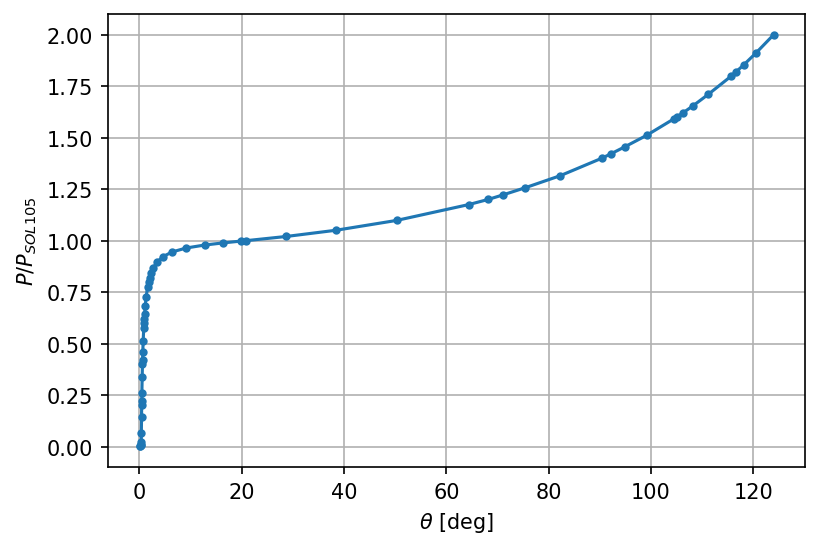

In [35]:
_, ax = plt.subplots()
ax.plot(np.rad2deg(displacement_history), load_history/sol105_buckling_load, '.-')
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()

Plot lowest eigenvalue of tangent stiffness matrix.

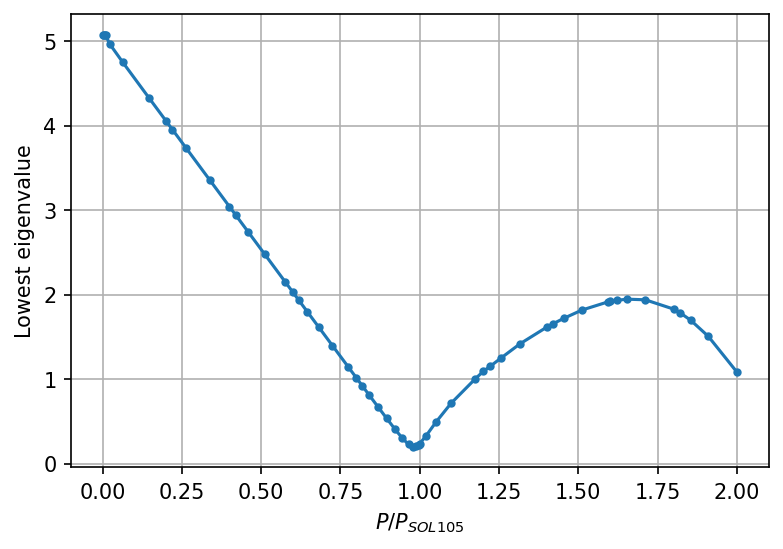

In [36]:
# Read the lowest eigenvalue of KLLRH matrices from f06 file
f06_filepath = os.path.join(analysis_directory_path, input_filename + '.f06')  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)
# Create new figure and plot load history vs lowest eigenvalues
_, ax = plt.subplots()
ax.plot(load_history/sol105_buckling_load, lowest_eigenvalues, '.-')
plt.xlabel('$P/P_{SOL 105}$')
plt.ylabel('Lowest eigenvalue')
plt.grid()
plt.show()

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [37]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()